## Recurrent Neural Network(Özyinelemeli Sinir Ağları)

### RNN ile Havayolu Yolcu Sayısı Tahmini

- Veri seti bir **zaman serisi** setidir.

- **Projede İzlenecek Adımlar:**
1. Business Problem(İş Problemi)
2. Data Understanding(Veriyi Anlamak)
3. Data Preparation(Veriyi Hazırlamak)
4. Modelling(Modelleme)
5. Evaluation(Değerlendirme)

#### 1. Business Problem(İş Problemi):

**Veri Setindeki Değişkenler**
- **Month:** Aylık olarak yer alan tarih değişkenidir.
- **Passengers:** İlgili işlem tarihindeki yolcu sayısını, yani aylık yolcu sayısını temsil etmektedir.

#### 2. Data Understanding(Veriyi Anlamak):

In [319]:
######################### Import İşlemleri ########################################

# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warningleri kapatmak için kullanılmaktadır
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [320]:
# Veri Setini Okuma
df = pd.read_csv("C:\\Users\\Monster\\Desktop\\dataa\\csv_files\\international-airline-passengers.csv")

In [321]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [322]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

- İkinci sütunun başlığı anlaşılır bir başlık değil bunu değiştirelim.

In [323]:
df.columns = ["Month", "Passengers"]

In [324]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [325]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [326]:
df.shape

(145, 2)

In [327]:
df.dtypes

Month          object
Passengers    float64
dtype: object

- Son satırdaki gözlem problemli old. için onu veri setinden çıkarmalıyız.
- "Month" değişkeninin veri tipi object imiş bunun da değişmesi ve zaman değişkeni yani datetime olması lazım.

In [328]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [329]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


#### 3. Data Preparation(Veriyi Hazırlamak):

In [330]:
# son satırdaki veri hatalı old. için onu atıyoruz veri setinden

df = df.iloc[:-1,:]
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [331]:
# "Month" değişkenini datetime tipine dönüştürüyoruz

df["Month"] = pd.to_datetime(df["Month"])

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [333]:
print("Minimum Tarih:", df["Month"].min())
print("Maximum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maximum Tarih: 1960-12-01 00:00:00


- Veri setindeki "Month" değişkeni aslında bizim indeksimiz yani modelleme esnasında modele verilecek olan değişken değil sadece indeks.

In [334]:
df.index = df["Month"]

In [335]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [336]:
df.drop("Month", axis=1, inplace=True)

In [337]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [338]:
result_df = df.copy()

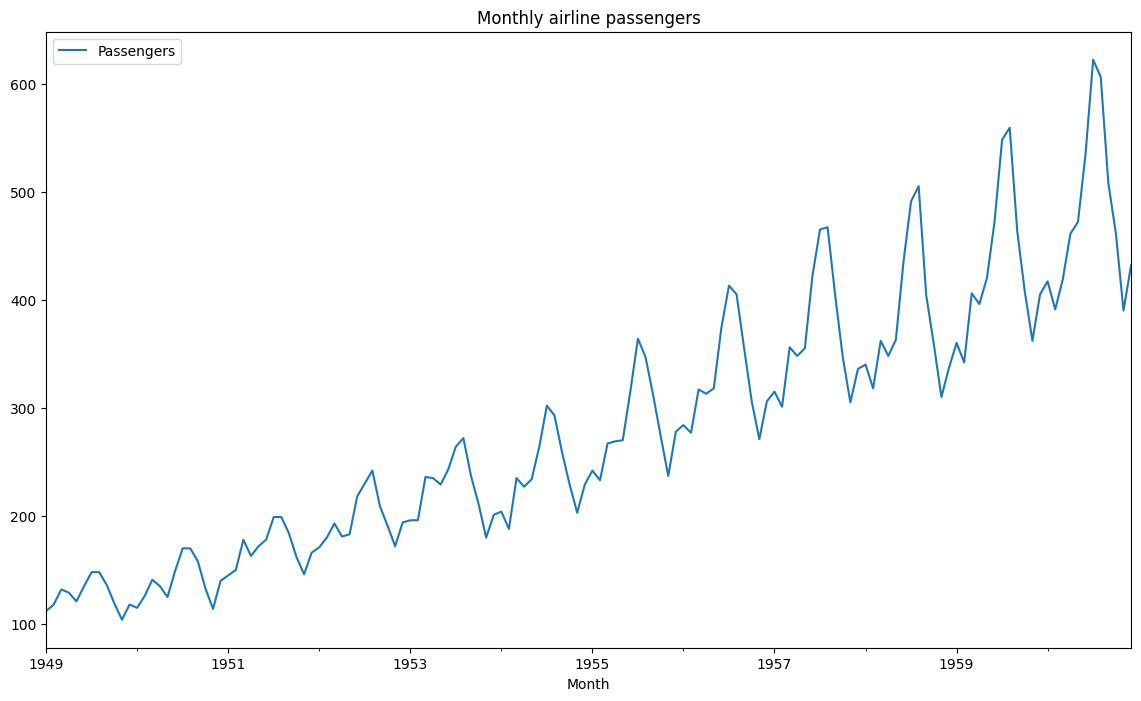

In [339]:
df.plot(figsize=(14,8), title='Monthly airline passengers');

- Yolcu sayısı genel olarak artış trendinde. Mevsimsel artış azalışlar da yaşanmış.

In [340]:
# veriyi numpy array'ine çevirmemiz gerekir
data = df["Passengers"].values

In [341]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [342]:
type(data[0:5])

numpy.ndarray

In [343]:
type(data[0])

numpy.float64

In [344]:
data = data.astype('float32')

In [345]:
type(data[0])

numpy.float32

In [346]:
data = data.reshape(-1,1)

In [347]:
data.shape

(144, 1)

- **Burda zaman serisi problemiyle ilgileniyor old. için veri setini skilearn kütüphanesinin "train_test_split" fonksiyonuyla test ve train olarak ayıramayız çünkü bu fonksiyon rastgele bir biçimde ayırır verileri. Ancak burada zaman serisi problemiyle ilgilendiğimiz için verileri rastgele gruplar halinde ayıramayız zira zaman serisi anlamında ortaya çıkabilecek örüntüyü kaybetmiş oluruz.**

In [348]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [349]:
# test size'ı %33 olarak belirledik
train, test, position = split_data(data, 0.33)

In [350]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [351]:
scaler_train = MinMaxScaler(feature_range=(0, 1))# # gradient descent temelli yöntemlerde eğitim süresini kısaltmak amacıyla değişkenler standartlaştırılır, 0 ila 1 arasına çekilir.
scaler_test = MinMaxScaler(feature_range=(0,1)) # # train ve test'e bu işlemler ayrı ayrı uygulanır, data lickage problemi olmaması için

train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

In [352]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [353]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

- RNN'e göre t anı en çok (t-1).andan etkilenir. Mesela satış değerlendirmesi yaparken Pazartesi gününü en çok etkileyen Pazar günki satışlardır. Haftalık bazda değerlendirirsek bu haftanın satışları için geçen haftanın satışlarına bakılır yani hep bir önceki değere bakılır.

In [354]:
# lookback=2 adım geriye bak ya da 1 adım geriye bak şeklinde kullanacağımız bir yapı

def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
        
    return np.array(X), np.array(Y)

In [355]:
lookback = 1

In [356]:
# train veri seti için
X_train, y_train = create_features(train, lookback)

In [357]:
# test veri seti için
X_test, y_test = create_features(test, lookback)

In [358]:
# bir önceki gözlem birimlerini alarak veri setine yeni değişkenler eklemiş olduk
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


- **RNN ,veri setini 3 boyutlu bir yapıda ister.**
- Bu nedenle reshape metoduyla yeniden boyutlandırma yapmamız gerekiyor.

In [359]:
# The process of converting the data set into the format requested by the RNN
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

#### 4. Modelling(Modelleme):

In [360]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))
model.add(Dense(1)) # çıkış katmanıdır ve 1 nöron var

In [361]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [362]:
# Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss='mean_squared_error', optimizer='adam')

In [363]:
callbacks = [ReduceLROnPlateau(monitor="val_loss", 
                               factor=0.2, 
                               patience=2, 
                               mode="min", 
                               verbose=1),
             
             EarlyStopping(monitor="val_loss", 
                           patience=5, 
                           verbose=1, 
                           mode="min", restore_best_weights=True)]

In [364]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs = 50,
                    batch_size = 1,
                    validation_data = (X_test,y_test),
                    callbacks = callbacks,
                    shuffle = False)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0250 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0221 - learning_rate: 0.0010
Epoch 8/50
57/95 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0099
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0214 - learning_rate: 0.0010
Epo

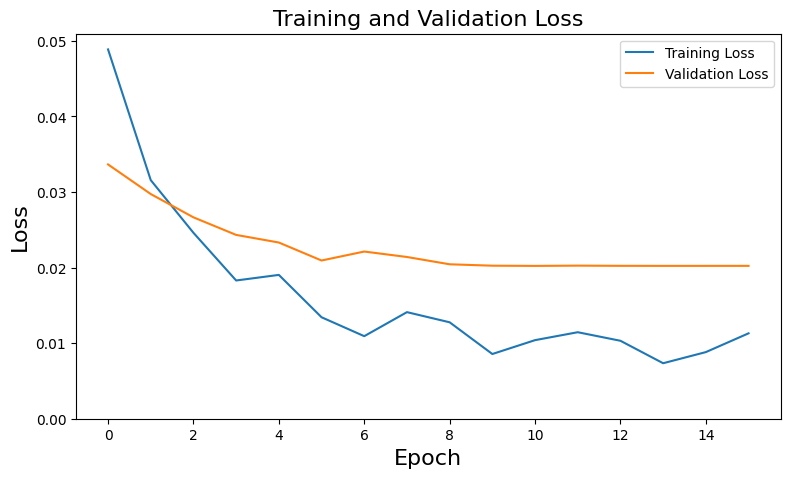

In [365]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

#### 5. Evaluation(Değerlendirme):

In [366]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest Loss: %.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 

Test Loss: 2.0%


In [367]:
train_predict = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [368]:
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [369]:
# veriyi hazırlama adımında model eğitimini kolaylaştırmak için veri setlerini standartlaştırmıştık(scale) bundan dolayı başarı oranı
# biraz gerçek üstülüğe yakın bir değer geldi, bu nedenle scale işlemini geri alıyoruz
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_train.inverse_transform(test_predict)

In [370]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_train.inverse_transform(y_test)

In [371]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [372]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [373]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 24.240067483033773
Test RMSE: 43.94071017566953


In [374]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [375]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [376]:
train_prediction_df = result_df[lookback:position]
train_prediction_df["Predicted"] = train_predict
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,135.114960
1949-03-01,132.0,138.006058
1949-04-01,129.0,147.279922
1949-05-01,121.0,144.914871
1949-06-01,135.0,139.524521


In [377]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,137.753876
1957-03-01,356.0,131.675644
1957-04-01,348.0,167.863144
1957-05-01,355.0,161.471924
1957-06-01,422.0,167.064270


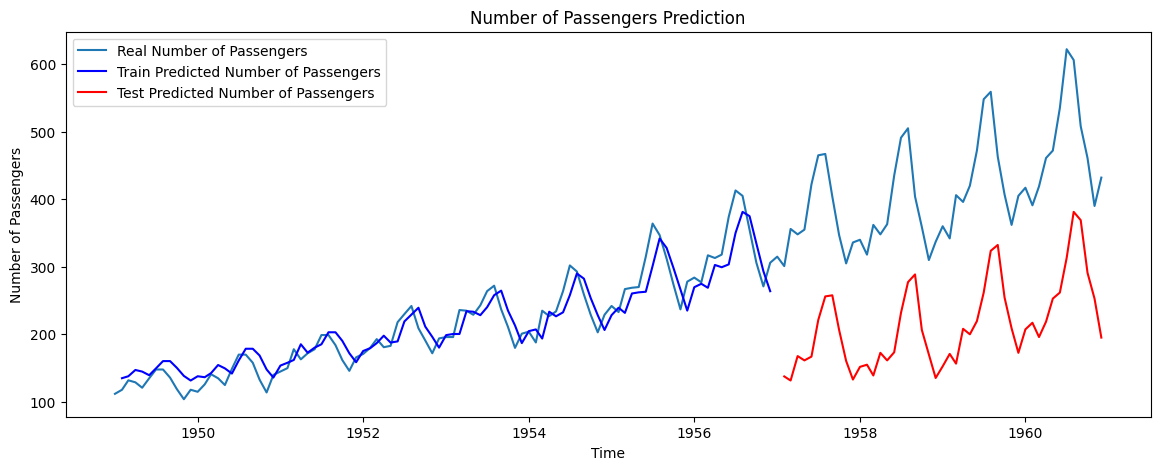

In [378]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()